In [1]:
from underworld import UWGeodynamics as GEO
from underworld import visualisation as vis
from underworld.scaling import non_dimensionalise as nd
from underworld.scaling import dimensionalise
 
import underworld as uw
from underworld import function as fn
import numpy as np
import math

u = GEO.UnitRegistry
#GEO.__version__

import os
import h5py   
import matplotlib.pyplot as plt
import numpy as np

loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
# input parameters
fdir_output = "tem"

xmin_box,xmax_box = -600,600             # unit [km]
ymin_box,ymax_box = -600,0 # unit [km]

x_box = xmax_box-xmin_box
y_box = -ymin_box+ymax_box

x_res,y_res = 960,480
npoints = 1200  
dx = x_box/x_res
dy = y_box/y_res


# scaling
ref_velocity = 1. * u.centimeter / u.year
ref_density = 3300. * u.kilogram / u.meter**3
ref_length = 600. * u.kilometer  
ref_gravity =  10.0 * u.meter / u.second**2
gravity = 10.0 * u.meter / u.second**2
#ref_vicosity = 1e21 * u.pascal * u.second

T0 = 273.15 * u.degK  # 0 * u.degC
Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

bodyforce = ref_density * ref_gravity
KL = ref_length
Kt = KL / ref_velocity
KM = bodyforce * KL**2 * Kt**2
KT = (Tz - T0)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

if uw.mpi.rank == 0:
    print('Length, km = ', GEO.dimensionalise(1., u.kilometer))
    print('Time, Myr = ',GEO.dimensionalise(1., u.megayear))
    print('Pressure, MPa = ',GEO.dimensionalise(1., u.megapascal))
    print('Temperature, K = ',GEO.dimensionalise(1., u.degK))
    print('Velocity, cm/yr = ',GEO.dimensionalise(1., u.centimeter / u.year))
    print('Viscosity, Pa S = ',GEO.dimensionalise(1.,u.pascal * u.second))
    
dx_nd = GEO.nd(dx*u.kilometer)
dy_nd = GEO.nd(dy*u.kilometer)

Length, km =  600.0 kilometer
Time, Myr =  60.0 megayear
Pressure, MPa =  19800.0 megapascal
Temperature, K =  1300.0 kelvin
Velocity, cm/yr =  0.9999999999999999 centimeter / year
Viscosity, Pa S =  3.749042879999999e+25 pascal * second


In [3]:
Model = GEO.Model(elementRes=(x_res, y_res),
                  minCoord=(xmin_box * u.kilometer, ymin_box*u.kilometer),
                  maxCoord=(xmax_box*u.kilometer, ymax_box*u.kilometer),
                  gravity=(0.0, -gravity))
Model.minStrainRate = 1e-18 / u.second

minCoord = tuple([GEO.nd(val) for val in Model.minCoord])
maxCoord = tuple([GEO.nd(val) for val in Model.maxCoord])

meshCopy = uw.mesh.FeMesh_Cartesian(elementType=Model.elementType,
                                    elementRes=Model.elementRes,
                                    minCoord=minCoord,
                                    maxCoord=maxCoord,
                                    periodic=Model.periodic)

	Global element size: 960x480
	Local offset of rank 0: 0x0
	Local range of rank 0: 960x480
In func WeightsCalculator_CalculateAll(): for swarm "Q6C8YVN0__swarm"
	done 33% (153600 cells)...
	done 67% (307200 cells)...
	done 100% (460800 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "Q6C8YVN0__swarm"
	Global element size: 960x480
	Local offset of rank 0: 0x0
	Local range of rank 0: 960x480


In [4]:
def load_mesh(fdir,meshCopy,step,remesh=False):
    if remesh:
        meshfile = fdir+"mesh-"+ str(step)+".h5"
        meshCopy.load(meshfile)
    else:
        meshfile = fdir+"mesh"+".h5"
        meshCopy.load(meshfile)
    return meshCopy
    
def load_mesh_variable(fdir,step,meshCopy,name,nodeDofCount):
    variableCopy =meshCopy.add_variable(nodeDofCount) 
    variablefile = fdir+ name + str(step) +'.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_swarm(fdir,meshCopy,step):
    swarmCopy = uw.swarm.Swarm(mesh=meshCopy,particleEscape=True)
    swarmfile = fdir+'swarm-' + str(step)  +'.h5'
    swarmCopy.load(swarmfile)
    return swarmCopy

def load_swarm_variable(fdir,step,swarmCopy,name,dataType,count):
    variableCopy = swarmCopy.add_variable(dataType, count)
    variablefile = fdir+ name + str(step)+'.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_tracer(fdir,step,name):
    fname = fdir + name + str(step) + ".h5"
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5["data"][()]
    return fdata

In [5]:
def load_mesh_top(fdir,meshCopy,step):
    mesh_tem = load_mesh(fdir,meshCopy,step,remesh=True)
    top = mesh_tem.specialSets['Top_VertexSet']
    return mesh_tem.data[top]

In [6]:
def load_mesh_IndexSet(fdir,meshCopy,step,IndexSet):
    mesh_tem = load_mesh(fdir,meshCopy,step,remesh=True)
    return mesh_tem.data[IndexSet]

In [7]:
D_moho = -35.*u.kilometer 
D_lab =  -100.*u.kilometer 
D_model =  -600.*u.kilometer 

d_moho0 = GEO.nd(D_moho)-dy_nd/4
d_moho1 = GEO.nd(D_moho)+dy_nd/4

from underworld.mesh import FeMesh_IndexSet
condition = np.where((Model.mesh.data[:,1]>= d_moho0)&(Model.mesh.data[:,1]<= d_moho1))
IndexSet = FeMesh_IndexSet(Model.mesh, topologicalIndex=0, size=Model.mesh.nodesGlobal, fromObject=condition[0])

In [23]:
fdir1 = "DefrmTop_Loading_FreeSlipBot_resx960/"
fdir2 = "DefrmMoho_Loading_FreeSlipBot_resx960/"
#fdir1 = "Loading_LithoBot/"

steps = np.array([1,10,100])
dt  = 10 #ka

case_name = "rhoc_tem_"
data_x = np.loadtxt(case_name+"topo_x.txt")
data_moho = np.loadtxt(case_name+"topo_m_time.txt")
data_surf = np.loadtxt(case_name+"topo_s_time.txt")
data_botm = np.loadtxt(case_name+"topo_b_time.txt")

# data_x_fixbot = np.loadtxt("fixbot_topo_x.txt")
# data_moho_fixbot  = np.loadtxt("fixbot_topo_m_time.txt")
# data_surf_fixbot  = np.loadtxt("fixbot_topo_s_time.txt")
# data_botm_fixbot  = np.loadtxt("fixbot_topo_b_time.txt")

data_nox = data_x.shape

In [10]:
# fname = fdir+"mesh-0.h5"
# fh5   = h5py.File(fname ,'r')  
# fdata = fh5["vertices"][()]
# x = fdata[:,0]
# (x[-1]-x[0])/(x[1]-x[0])

### Analytical_FreeSlipBot vs Analytical_FreeSurfBot

In [11]:
# fname = "Topography-" #+str(step)
# fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
# ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
# ax1.set_xlim([xmin_box,xmax_box])
# for i,step in enumerate(steps):
#     Time = step*dt
#     ax1.plot(data_x+600,data_surf[:,i+1],"k-",label="Vel")
#     ax1.plot(data_x,data_surf[::-1,i+1],"k-",label="Vel")
#     ax1.plot(data_x_fixbot+600,data_surf_fixbot[:,i+1],"r--",label="Vel")
#     ax1.plot(data_x_fixbot,data_surf_fixbot[::-1,i+1],"r--",label="Vel")
#     #plt.text(xmax_box/2,coords[:,1].max() , str(Time)+" ka", ha='center',fontsize=10, color='k')
# #fig.savefig("topo")   

### NM_FreeSlipBot vs Analytical_FreeSurf

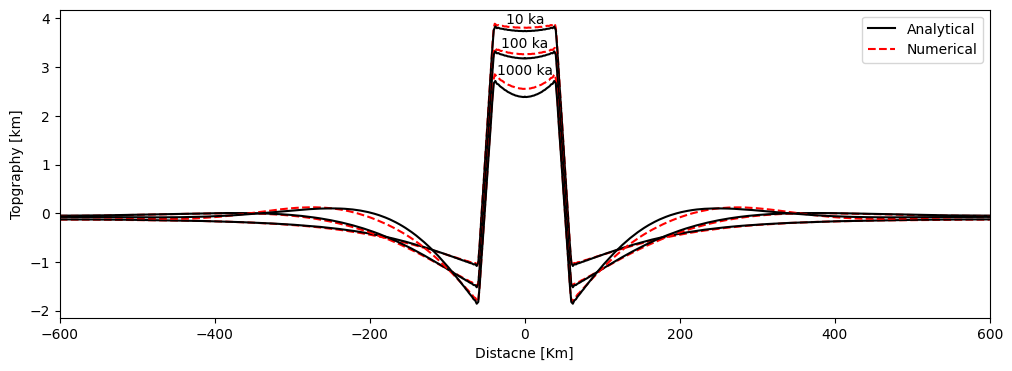

In [45]:
NM_case_name = "_DefTop_"

fname = "Topography-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    ax1.plot(coords[:,0],coords[:,1],"r--") #,label="Vel")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0],coords[:,1],"b-",label="Vel")
    ax1.plot(data_x,data_surf[:,i],"k-")#,label="Vel")
    ax1.plot(data_x-600,data_surf[::-1,i],"k-")#,label="Vel")
    plt.text(0.,coords[:,1].max() , str(Time)+" ka", ha='center',fontsize=10, color='k')
ax1.plot(0,0,"k-",label="Analytical")
ax1.plot(0,0,"r--",label="Numerical")
plt.legend(loc='upper right') 
fig.savefig(case_name+NM_case_name+"topo")   

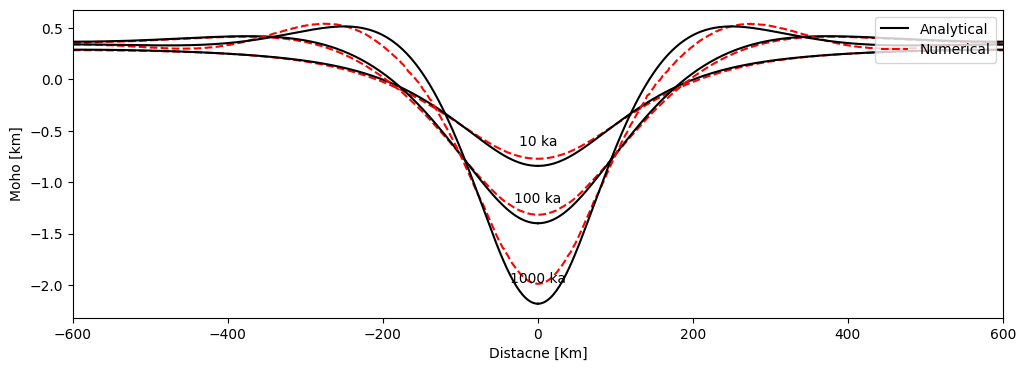

In [46]:
NM_case_name = "_DefTop_"

fname = "Moho-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Moho [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    coords = load_tracer(fdir1,step,"Moho-") 
    #ax1.plot(coords[:,0],coords[:,1]+35,"y-")#,label="Vel")
    #coords = load_mesh_IndexSet(fdir1,meshCopy,step,IndexSet)*ref_length.m
    ax1.plot(coords[:,0],coords[:,1]+35,"r--")#,label="Vel")
    ax1.plot(data_x,data_moho[:,i],"k-")#,label="Vel")
    ax1.plot(data_x-600,data_moho[::-1,i],"k-")#,label="Vel")
    plt.text(0.,data_moho[:,i].min()+.2, str(Time)+" ka", ha='center',fontsize=10, color='k')
ax1.plot(0,0,"k-",label="Analytical")
ax1.plot(0,0,"r--",label="Numerical")
plt.legend(loc='upper right') 
fig.savefig(case_name+NM_case_name+"moho")   

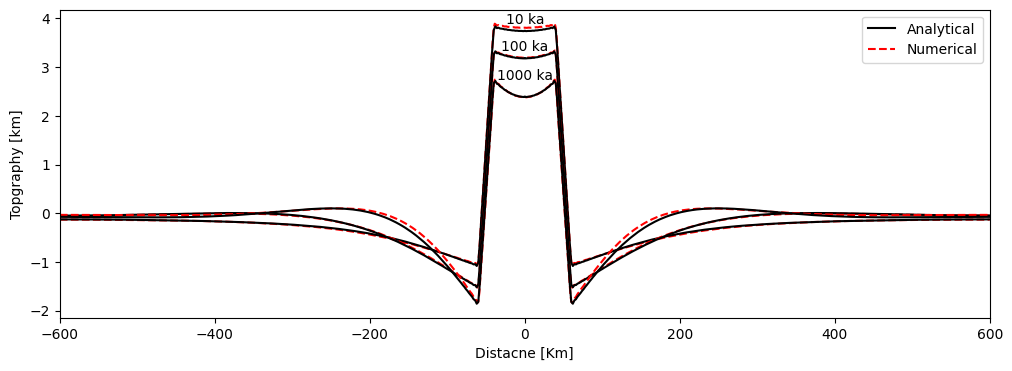

In [49]:
NM_case_name = "_DefMoho_"

fname = "Topography-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    coords = load_mesh_top(fdir2,meshCopy,step)*ref_length.m
    ax1.plot(coords[:,0],coords[:,1],"r--")#,label="Vel")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0],coords[:,1],"b-",label="Vel")
    ax1.plot(data_x,data_surf[:,i],"k-")#,label="Vel")
    ax1.plot(data_x-600,data_surf[::-1,i],"k-")#,label="Vel")
    plt.text(0.,coords[:,1].max() , str(Time)+" ka", ha='center',fontsize=10, color='k')
ax1.plot(0,0,"k-",label="Analytical")
ax1.plot(0,0,"r--",label="Numerical")
plt.legend(loc='upper right') 
fig.savefig(case_name+NM_case_name+"topo")   

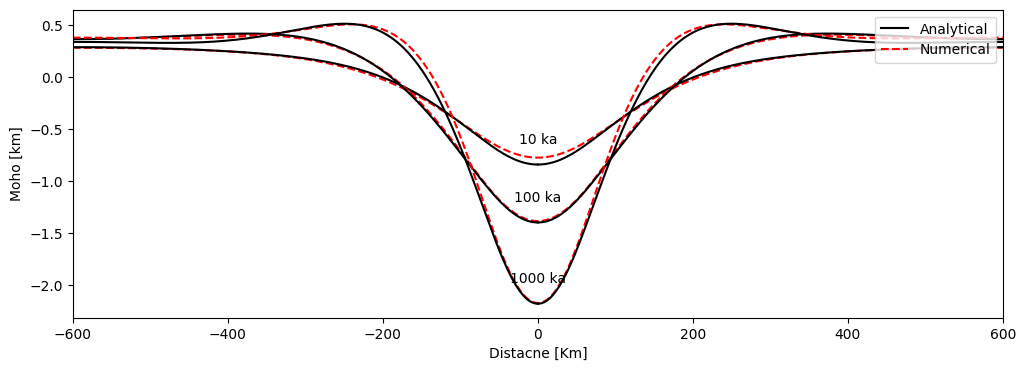

In [48]:
NM_case_name = "_DefMoho_"

fname = "Moho-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Moho [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
#     coords = load_tracer(fdir,step,"Moho-") 
#     ax1.plot(coords[:,0],coords[:,1]+35,"y-",label="Vel")
    coords = load_mesh_IndexSet(fdir2,meshCopy,step,IndexSet)*ref_length.m
    ax1.plot(coords[:,0],coords[:,1]+35,"r--")#,label="Vel")
    ax1.plot(data_x,data_moho[:,i],"k-")#,label="Vel")
    ax1.plot(data_x-600,data_moho[::-1,i],"k-")#,label="Vel")
    plt.text(0.,data_moho[:,i].min()+.2, str(Time)+" ka", ha='center',fontsize=10, color='k')
ax1.plot(0,0,"k-",label="Analytical")
ax1.plot(0,0,"r--",label="Numerical")
plt.legend(loc='upper right') 
fig.savefig(case_name+NM_case_name+"moho")   

### Error in HPC

TField.data[top, 0] = H0
ValueError: shape mismatch: value array of shape (1201,) could not be broadcast to indexing result of shape (0,)



FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
(0,)
FeMesh_IndexSet([])
FeMesh_IndexSet([])
(0,)
(0,)
FeMesh_IndexSet([44700, 44701, 44702, 44703, 44704, 44705, 44706, 44707, 44708,
       44709, 44710, 44711, 44712, 44713, 44714, 44715, 44716, 44717,
       44718, 44719, 44720, 44721, 44722, 44723, 44724, 44725, 44726,
       44727, 44728, 44729, 44730, 44731, 44732, 44733, 44734, 44735,
       44736, 44737, 44738, 44739, 44740, 44741, 44742, 44743, 44744,
       44745, 44746, 44747, 44748, 44749, 44750, 44751, 44752, 44753,
       44754, 44755, 44756, 44757, 44758, 44759, 44760, 44761, 44762,
       44763, 44764, 44765, 44766, 44767, 44768, 44769, 44770, 44771,
       44772, 44773, 44774, 44775, 44776, 44777, 44778, 44779, 44780,
       44781, 44782, 44783, 44784, 44785, 44786, 44787, 44788, 44789,